# Chapter 6.5

In this notebook, we tackle the problem of portfolio optimizatio from the perspective of deep learning. We introduce an end-to-end framework that utilizes deep learning models to directly optimize a portfolio.

In [1]:
import os 
import sys
current_dir = os.path.dirname(os.path.abspath("__file__"))
project_dir = os.path.dirname(current_dir)
sys.path.append(project_dir)

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn

from Utilis.early_stopper import EarlyStopping
from Utilis.metrics import report_metrics
from Utilis.torch_data import MyDataset

In [2]:
def read_data(data_path):
    df = pd.read_csv(data_path)
    df.index = pd.to_datetime(df['Date'])
    df = df.drop(columns=['Date'])
    train_data = df[:'2017']
    val_data = pd.concat((df.loc["2018"], df.loc['2019']))
    test_data = pd.concat((df.loc["2020"], df.loc['2022':]))
    return train_data, val_data, test_data
    
def data_classification(X, k, T):
    [N, D] = X.shape
    df = np.array(X)
    dataX = np.zeros((N - T + 1, T, D))
    for i in range(T, N + 1):
        dataX[i - T] = df[i - T:i, :]
    return dataX[:-k]

def prepare_y(data, k, T):
    return np.array(data[T-1 + k:])

In [3]:
def Neg_Sharpe(portfolio):
    return -torch.mean(portfolio)/torch.std(portfolio)

class Utility(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, outputs, future_rets):
        portflio = outputs * future_rets 
        portflio = torch.sum(portflio, dim=1)
        loss = Neg_Sharpe(portflio)
        return loss

class MLP(nn.Module):
    def __init__(self, seq_length, n_features, y_dim):
        super().__init__()

        self.fc = nn.Sequential(
            nn.Flatten(),       
            nn.Linear(seq_length*n_features, 4),
            nn.Tanh(),
            nn.Linear(4, y_dim))

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        y = torch.softmax(x, dim=1)
        return y   


def train_model(model, train_data_loader, val_data_loader, X_test, savepath, epochs=5, lr=1e-3, patience=5):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = Utility()
    early_stopper = EarlyStopping(savepath=savepath, patience=patience, min_delta=1e-4, verbose=True)
    for epoch in range(epochs):
        train_epoch_loss = []
        val_epoch_loss = []
        
        model.train()
        for batch_X, batch_y in train_data_loader:
            optimizer.zero_grad()
            out = model(batch_X)
            loss = criterion(out, batch_y)
            loss.backward()
            optimizer.step()
            train_epoch_loss.append(loss.item())

        model.eval()
        for batch_X, batch_y in val_data_loader:
            with torch.no_grad():
                out = model(batch_X)
                loss = criterion(out, batch_y)
                val_epoch_loss.append(loss.item())
        
        train_epoch_loss = np.mean(train_epoch_loss)
        val_epoch_loss = np.mean(val_epoch_loss)

        print(f"Epoch {epoch+1}/{epochs}, "
              f"Train loss: {train_epoch_loss:.4f}, "
              f"Validation loss: {val_epoch_loss:.4f}")
        
        early_stopper(model, val_epoch_loss)
        if early_stopper.early_stop:
            print("Early stopping triggered!")
            break
    
    model.load_state_dict(torch.load(savepath))
    model.eval()
    y_pred_test = model(torch.from_numpy(X_test.astype(np.float32)))
    return model, y_pred_test.detach().cpu().numpy()           

In [4]:
data_path = '../Data/portfolio_data.csv'
T = 10
k = 1

In [5]:
ticker_list = ['AXP', 'CI', 'GD', 'HON', 'MMM',
              'MO', 'MRK', 'PFE', 'PG', 'SO', 
              'NEM', 'NSC', 'GE', 'AEP', 'AAPL', 
              'ABT', 'SNA', 'PTC', 'BAC', 'NKE'] 

train_data, val_data, test_data = read_data('../Data/portfolio_data.csv')

In [6]:
train_x = data_classification(train_data[[tic + '_Return' for tic in ticker_list]], k, T)
train_y = prepare_y(train_data[[tic + '_Return' for tic in ticker_list]], k, T)

val_x = data_classification(val_data[[tic + '_Return' for tic in ticker_list]], k, T)
val_y = prepare_y(val_data[[tic + '_Return' for tic in ticker_list]], k, T)

test_x = data_classification(test_data[[tic + '_Return' for tic in ticker_list]], k, T)
test_y = prepare_y(test_data[[tic + '_Return' for tic in ticker_list]], k, T)

print(train_x.shape, train_y.shape)
print(val_x.shape, val_y.shape)
print(test_x.shape, test_y.shape)

(6311, 10, 20) (6311, 20)
(493, 10, 20) (493, 20)
(469, 10, 20) (469, 20)


In [7]:
train_loader = torch.utils.data.DataLoader(dataset=MyDataset(train_x, train_y), batch_size=512, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=MyDataset(val_x, val_y), batch_size=512, shuffle=False)


In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = MLP(T, len(ticker_list), y_dim = len(ticker_list))
model.to(device)
model, y_pred = train_model(model, train_loader, val_loader, test_x, savepath='./model/best_mlp', epochs=1000, lr=0.001, patience=50)

Using device: cpu
Epoch 1/1000, Train loss: -0.0585, Validation loss: -0.0436
Epoch 2/1000, Train loss: -0.0589, Validation loss: -0.0436
No improvement in validation loss. Counter: 1/50
Epoch 3/1000, Train loss: -0.0594, Validation loss: -0.0437
No improvement in validation loss. Counter: 2/50
Epoch 4/1000, Train loss: -0.0574, Validation loss: -0.0437
Validation loss improved. Resetting counter.
Epoch 5/1000, Train loss: -0.0552, Validation loss: -0.0437
No improvement in validation loss. Counter: 1/50
Epoch 6/1000, Train loss: -0.0575, Validation loss: -0.0438
No improvement in validation loss. Counter: 2/50
Epoch 7/1000, Train loss: -0.0599, Validation loss: -0.0438
No improvement in validation loss. Counter: 3/50
Epoch 8/1000, Train loss: -0.0562, Validation loss: -0.0438
No improvement in validation loss. Counter: 4/50
Epoch 9/1000, Train loss: -0.0646, Validation loss: -0.0438
No improvement in validation loss. Counter: 5/50
Epoch 10/1000, Train loss: -0.0608, Validation loss: -

In [11]:
port_ret = np.array(test_y) * np.array(y_pred)
port_ret = np.sum(port_ret, axis=1)
port_cumret = np.cumsum(port_ret)

In [12]:
print(report_metrics(port_ret))


{'annual_ret': np.float64(0.05745924501737948), 'annual_std': np.float64(0.2852782844088769), 'annual_sharpe': np.float64(0.20141471733973854)}


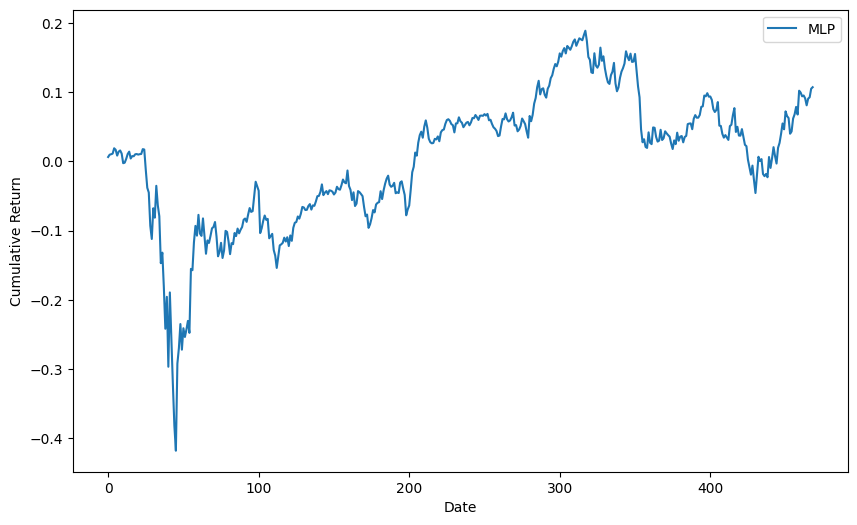

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(port_cumret, label="MLP")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()